## PCA

We're going to run PCA on efferent and afferent connectivity matrices, so we can look at differences between hippocampal afferent and efferent connectivity. We predict that connections to the hippocampus connect more or less equally across all subregions of the hippocampus, so we should see more principal components, each explaining less variance. Conversely, we predict that connections coming out of the hippocampus are more functionally specialized and thus we should see fewer principal components, with the first few explaining most of the variance--this is because outputs cluster in more distinct patterns (outputs really define the function of a region) and thus the variance in connectivity profiles can be defined by fewer clusters.

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from helpers import plot_incoming_outgoing_PCA, get_feature_vectors_shared_hpc, get_correlation_matrix

In [76]:
## Helper Function for PCA components
def get_pca_variances(matrix1, matrix2, n_components):
    """
    Runs PCA on two (samples, samples) matrices and returns the
    element-wise difference in their explained variance ratios.
    """
    # CHANGE: We must transpose the matrices to (n_samples, n_features)
    # before fitting them with sklearn's PCA.
    # CHANGE: Sstandardize the data
    # scaler = StandardScaler()
    # afferent_scaled = scaler.fit_transform(matrix1)
    # efferent_scaled = scaler.fit_transform(matrix2)
    
    pca1 = PCA(n_components=n_components, svd_solver='full')
    pca1.fit(matrix1)
    vars_a = pca1.explained_variance_ratio_
    
    pca2 = PCA(n_components=n_components, svd_solver='full')
    pca2.fit(matrix2) # Fit on (N_ROIS, N_FEATURES)
    vars_e = pca2.explained_variance_ratio_
    
    return (vars_a, vars_e)

In [77]:
## Helper Function for PCA Differences - DO NOT SCALE DATA FOR THIS ITERATION!

def get_pca_variance_diffs(matrix1, matrix2, n_components):
    """
    Runs PCA on two (samples, samples) matrices and returns the
    element-wise difference in their explained variance ratios.
    """
    
    pca1 = PCA(n_components=n_components, svd_solver='full')
    pca1.fit(matrix1)
    vars1 = pca1.explained_variance_ratio_
    
    pca2 = PCA(n_components=n_components, svd_solver='full')
    pca2.fit(matrix2) 
    vars2 = pca2.explained_variance_ratio_
    
    # Return the difference for each component (e.g., [PC1_diff, PC2_diff, ...])
    return vars1 - vars2

In [2]:
df_avg_to_shared, df_avg_from_shared = get_feature_vectors_shared_hpc()

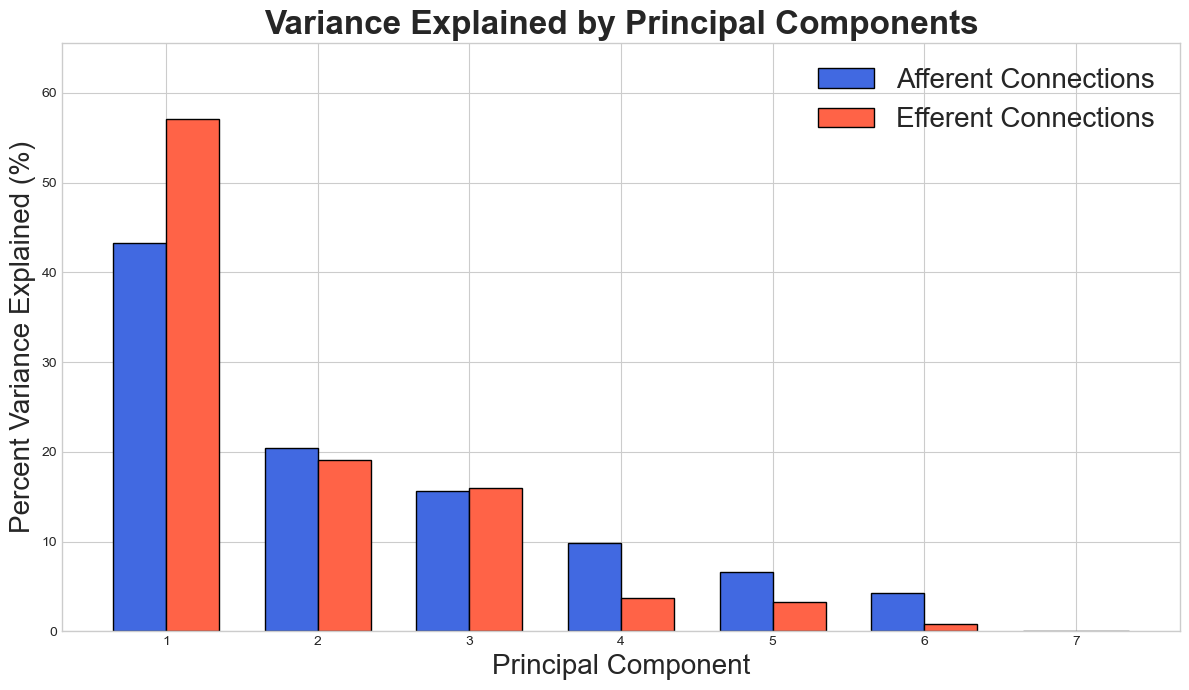

In [3]:
# PCA on feature vectors
fig = plot_incoming_outgoing_PCA(incoming_distance = df_avg_to_shared,
                           outgoing_distance = df_avg_from_shared, 
                           n_components=7,
                           scale=True)

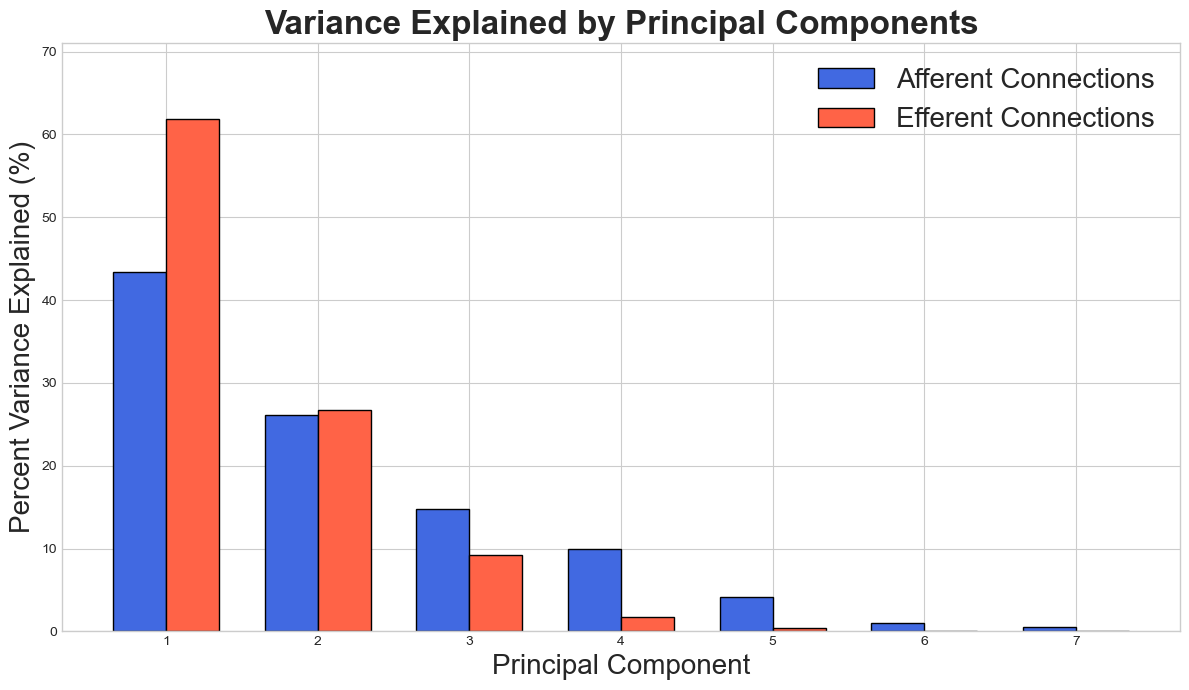

In [19]:
# PCA on similarity matrix

df_cosine_to_shared = get_correlation_matrix(df_avg_to_shared, 'cosine')
df_cosine_from_shared = get_correlation_matrix(df_avg_from_shared, 'cosine')

fig = plot_incoming_outgoing_PCA(incoming_distance = df_cosine_to_shared,
                           outgoing_distance = df_cosine_from_shared, 
                           n_components=7,
                           scale=False)

In [78]:
vars_a, vars_e = get_pca_variances(df_cosine_to_shared, df_cosine_from_shared, 7)
vars_e - vars_a

array([ 0.18437491,  0.00630866, -0.05639378, -0.08096725, -0.03722219,
       -0.01018957, -0.00591079])

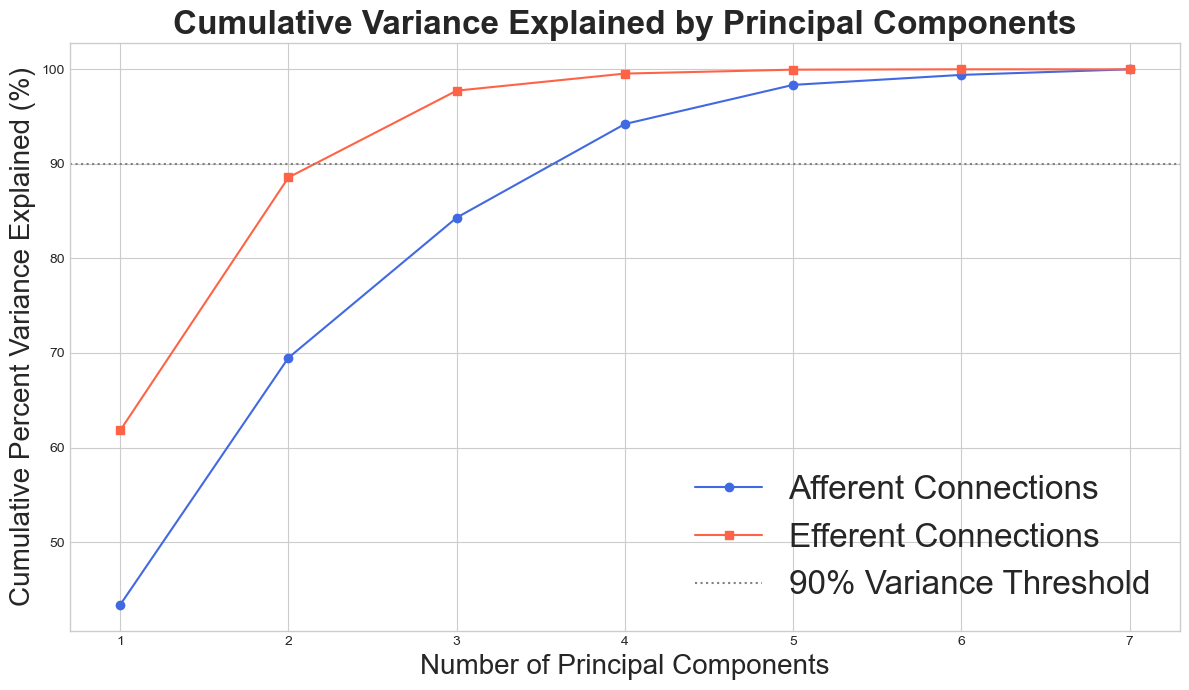

In [27]:
from helpers import plot_incoming_outgoing_PCA_cumulative


# Call the new function
fig = plot_incoming_outgoing_PCA_cumulative(
    df_cosine_to_shared, 
    df_cosine_from_shared, 
    n_components=7, 
    scale=False
)
fig.savefig('../output/PCA_cumulative_variance.png')

# Bootstrapping using Cosine Similarity Matrices

In [79]:
df_cosine_to_shared = get_correlation_matrix(df_avg_to_shared, 'cosine')
df_cosine_from_shared = get_correlation_matrix(df_avg_from_shared, 'cosine')

cosine_eff_shared_vals = df_cosine_from_shared.values
cosine_aff_shared_vals = df_cosine_to_shared.values

real_diffs = get_pca_variance_diffs(cosine_eff_shared_vals, 
                                     cosine_aff_shared_vals,
                                     7)
real_diffs

array([ 0.18437491,  0.00630866, -0.05639378, -0.08096725, -0.03722219,
       -0.01018957, -0.00591079])

In [80]:
def get_null_matrices(df_avg_to, df_avg_from):
    df_null_afferent = df_avg_to.copy(deep=True)
    df_null_efferent = df_avg_from.copy(deep=True)
    
    rois = df_null_afferent.columns
    
    for region in rois:
        swap = np.random.binomial(n=1, p=0.5)
        if swap:
            temp = df_avg_to[region]
            df_null_afferent[region] = df_avg_from[region]
            df_null_efferent[region] = temp
            
    return (df_null_efferent, df_null_afferent)

In [66]:
# --- BOOTSTRAP THE CORRELATION MATRICES ----

import random
from helpers import get_correlation_matrix

num_iterations = 2000

null_distribution_afferent = []
null_distribution_efferent = []
null_distribution_diffs = []


for i in range(num_iterations):
    # get null matrices
    df_null_efferent, df_null_afferent = get_null_matrices(df_avg_to_shared, df_avg_from_shared)

    null_eff_vals = df_null_efferent.values
    null_aff_vals = df_null_afferent.values

    # Get cosine similarity matrices for shuffled data
    cosine_values_A = cosine_similarity(null_aff_vals.T)
    cosine_values_E = cosine_similarity(null_eff_vals.T)
    
    # Perform PCA on Both Datasets
    n_components = 7
    null_a, null_e = get_pca_variances(null_aff_vals, null_eff_vals, n_components)
    
    # Store the result
    null_distribution_afferent.append(null_a)
    null_distribution_efferent.append(null_e)

    diffs = null_a - null_e
    null_distribution_diffs.append(diffs)

In [67]:
# Convert list to a 2D NumPy array for easy analysis
# Shape is (N_PERMUTATIONS, N_COMPONENTS)
null_distribution_diffs = np.array(null_distribution_diffs)


## 5. Step 4: Analyze Results and Compare
# --- This entire section is identical to before ---
# It just analyzes the final 'null_distribution' array.
print("\n--- Final Analysis ---")

bootstrap_lower_bound = []
bootstrap_upper_bound = []

for i in range(7):
    pc_label = f"PC{i+1}"
    real_diff = real_differences[i]
    
    # Get the null distribution for *this specific component*
    null_dist_pc = null_distribution_diffs[:, i] # This is a 1D array
    
    # Find the 95% confidence interval
    lower_bound = np.percentile(null_dist_pc, 2.5)
    upper_bound = np.percentile(null_dist_pc, 97.5)

    bootstrap_lower_bound.append(lower_bound)
    bootstrap_upper_bound.append(upper_bound)
    
    # Calculate a two-tailed p-value
    extreme_count = np.sum(np.abs(null_dist_pc) >= np.abs(real_diff))
    p_value = (extreme_count + 1) / (num_iterations + 1)

    print(f"\n{pc_label} Analysis:")
    print(f"  Real Difference: {real_diff:.4f}")
    print(f"  95% Null Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"  p-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"  Result: SIGNIFICANT. The difference is unlikely due to chance.")
    else:
        print(f"  Result: NOT SIGNIFICANT. The difference is within the range of random chance.")


--- Final Analysis ---

PC1 Analysis:
  Real Difference: -0.1844
  95% Null Interval: [-0.1263, 0.1269]
  p-value: 0.0040
  Result: SIGNIFICANT. The difference is unlikely due to chance.

PC2 Analysis:
  Real Difference: -0.0063
  95% Null Interval: [-0.0867, 0.0856]
  p-value: 0.9190
  Result: NOT SIGNIFICANT. The difference is within the range of random chance.

PC3 Analysis:
  Real Difference: 0.0564
  95% Null Interval: [-0.0489, 0.0497]
  p-value: 0.0240
  Result: SIGNIFICANT. The difference is unlikely due to chance.

PC4 Analysis:
  Real Difference: 0.0810
  95% Null Interval: [-0.0309, 0.0321]
  p-value: 0.0005
  Result: SIGNIFICANT. The difference is unlikely due to chance.

PC5 Analysis:
  Real Difference: 0.0372
  95% Null Interval: [-0.0292, 0.0294]
  p-value: 0.0080
  Result: SIGNIFICANT. The difference is unlikely due to chance.

PC6 Analysis:
  Real Difference: 0.0102
  95% Null Interval: [-0.0200, 0.0189]
  p-value: 0.3203
  Result: NOT SIGNIFICANT. The difference is w

In [68]:
real_differences

array([-0.18437491, -0.00630866,  0.05639378,  0.08096725,  0.03722219,
        0.01018957,  0.00591079])

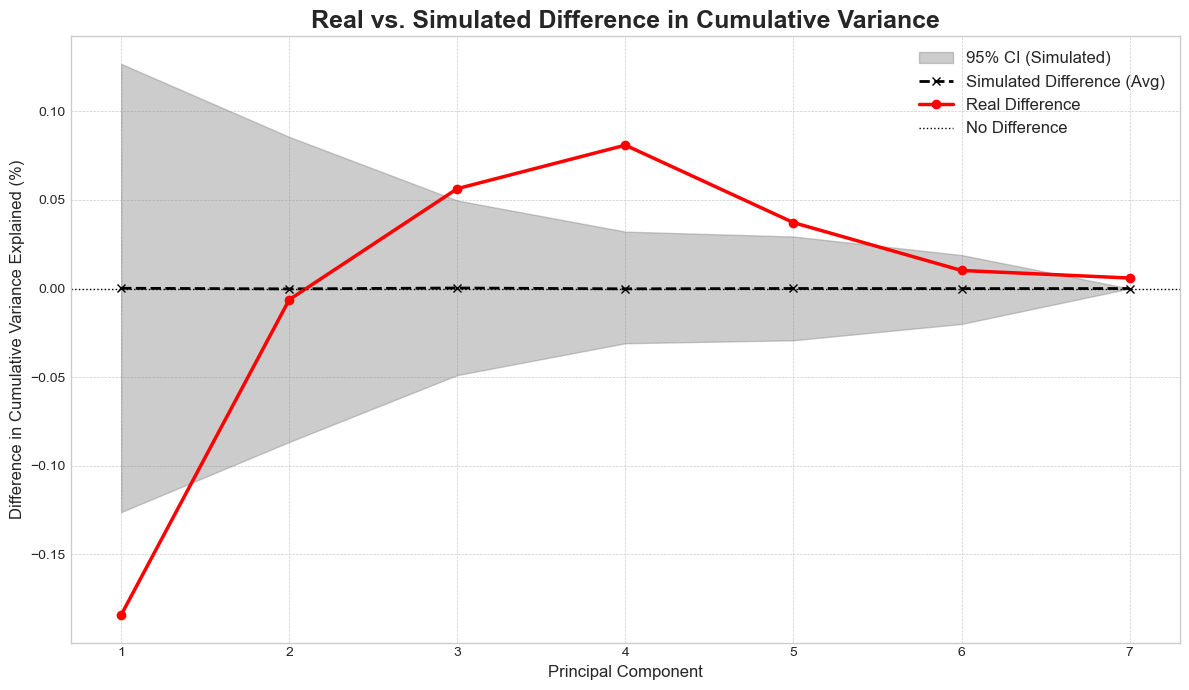

In [69]:
from helpers import plot_variance_differences

# --- Example Usage ---
np.random.seed(42)

average_simulated_differences = np.mean(null_distribution_diffs, axis=0)

# Call the function
fig = plot_variance_differences(
    real_differences=real_differences,
    simulated_differences=average_simulated_differences,
    bootstrap_ci_lower=bootstrap_lower_bound,
    bootstrap_ci_upper=bootstrap_upper_bound
)


In [70]:
real_differences

array([-0.18437491, -0.00630866,  0.05639378,  0.08096725,  0.03722219,
        0.01018957,  0.00591079])

In [71]:
average_simulated_differences = np.mean(null_distribution_diffs, axis=0)

In [72]:
average_simulated_differences

array([ 1.47546676e-04, -2.14934979e-04,  2.85910548e-04, -1.82447740e-04,
        1.69342866e-05, -5.30087921e-05,  8.61255520e-35])